In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
clobber = False

In [4]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
try:
    cluster
    client
except:
    cluster = NCARCluster(project='UCUC0006')
    cluster.scale(35)
    client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.22:38507 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## compute retrospective trends 

In [5]:
%%time
name = 'cesm-le-djf-retro-trends-trans'
@xp.persist_ds(name=name, format='zarr', path=util.project_tmpdir, trust_cache=True, clobber=clobber)
def retro_trends():

    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr') 
    
    # set up trend dimensions
    trend_year = xr.DataArray(np.arange(2000, 2101, 1), dims=('time'))
    trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

    # loop over trends
    ds_list = []
    for end_year, n_year in product(trend_year.values, trend_length.values):

        # subset data for the time-period of this trend
        ds = ds_djf.sel(time=slice(end_year-n_year+1, end_year))
        if len(ds.time) != n_year: 
            continue

        # loop over vars and compute trends
        da_list = []
        for v in ds.data_vars:
            da = util.linear_trend(
                ds[v]
            ).expand_dims(
                trend_length=[n_year], 
                trend_year=[end_year]
            ) * 10.
            da.attrs = ds[v].attrs
            da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
            da_list.append(da)
            
        ds_list.append(xr.merge(da_list))

    return xr.combine_by_coords(ds_list) #.compute()

ds = retro_trends()
ds

writing cache file: /glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-djf-retro-trends-trans.zarr


KeyError: '.zgroup'

In [6]:
%%time
name = 'cesm-le-djf-prospective-trends-trans'
@xp.persist_ds(name=name, format='zarr', path=util.project_tmpdir, trust_cache=True, clobber=clobber)
def prospective_trends():

    ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr') 
    
    # set up trend dimensions
    trend_year = xr.DataArray([2006, 2020,], dims=('time'))
    trend_length = xr.DataArray([5, 10, 20, 50], dims=('trend_length'))

    # loop over trends
    ds_list = []
    for start_year, n_year in product(trend_year.values, trend_length.values):

        # subset data for the time-period of this trend
        ds = ds_djf.sel(time=slice(start_year, start_year+n_year-1))
        if len(ds.time) != n_year: 
            continue

        # loop over vars and compute trends
        da_list = []
        for v in ds.data_vars:
            da = util.linear_trend(
                ds[v]
            ).expand_dims(
                trend_length=[n_year], 
                trend_year=[start_year]
            ) * 10.
            da.attrs = ds[v].attrs
            da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
            da_list.append(da)
            
        ds_list.append(xr.merge(da_list))

    return xr.combine_by_coords(ds_list) #.compute()

ds = prospective_trends()
ds

writing cache file: /glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-djf-prospective-trends-trans.zarr


KeyError: '.zgroup'

In [7]:
ds.Chl_surf.sel(trend_year=2020, trend_length=50).mean('member_id').plot()

NameError: name 'ds' is not defined

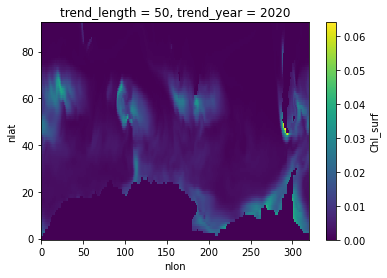

In [11]:
ds.Chl_surf.sel(trend_year=2020, trend_length=50).std('member_id').plot()